# Linear Regression using Gradient Descent

- `Pandas`, `Scikit-learn` for cleaning data
- `Matplotlib`, `Seaborn` for some basic visualizations
- `NumPy` for scaling and predictions

### 1. Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy, math

from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error

### 2. Loading the `train` dataset
Before starting on any task, it is useful to get more familiar with your dataset.

In [2]:
df_train = pd.read_csv('train.csv').set_index('Id')
print ('The shape of df_train is: ', df_train.shape)
df_train.head(2)

The shape of df_train is:  (1460, 80)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


- Target values are stored in a Numpy scalar `y_train`

In [3]:
y_train = np.array(df_train['SalePrice'])
# print y_train
print(f"y_train Shape: {y_train.shape}, y_train Type: {type(y_train)})")
print("First element of y_train are:\n", y_train[:])
print("Dimension of y_train:", y_train.ndim)

y_train Shape: (1460,), y_train Type: <class 'numpy.ndarray'>)
First element of y_train are:
 [208500 181500 223500 ... 266500 142125 147500]
Dimension of y_train: 1


### 3. Visualize your data
* Correlated columns with `SalePrice`

In [4]:
corr = df_train.corr()
corr.sort_values(['SalePrice'], ascending=False, inplace=True)
corr.SalePrice.head(7)

SalePrice      1.000000
OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
TotalBsmtSF    0.613581
1stFlrSF       0.605852
Name: SalePrice, dtype: float64

- It is often useful to understand the data by visualizing it.

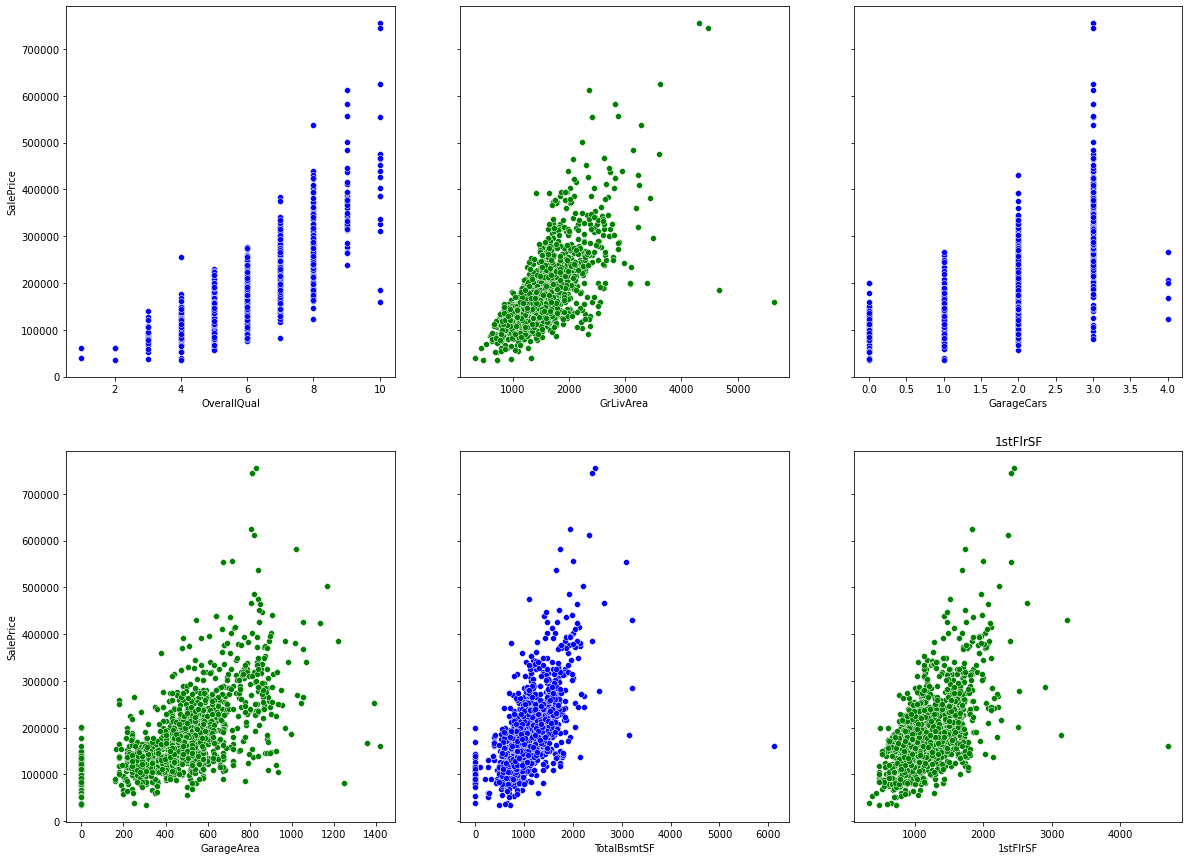

In [5]:
fig, axes = plt.subplots(2,3, figsize=(20,15), sharey=True)

plt.title('OverallQual')
sns.scatterplot(ax=axes[0,0], data=df_train, x='OverallQual', y='SalePrice', color='b')
plt.title('GrLivArea')
sns.scatterplot(ax=axes[0,1], data=df_train, x='GrLivArea', y='SalePrice', color='g')
plt.title('GarageCars')
sns.scatterplot(ax=axes[0,2], data=df_train, x='GarageCars', y='SalePrice', color='b')
plt.title('GarageArea')
sns.scatterplot(ax=axes[1,0], data=df_train, x='GarageArea', y='SalePrice', color='g')
plt.title('TotalBsmtSF')
sns.scatterplot(ax=axes[1,1], data=df_train, x='TotalBsmtSF', y='SalePrice', color='b')
plt.title('1stFlrSF')
sns.scatterplot(ax=axes[1,2], data=df_train, x='1stFlrSF', y='SalePrice', color='g')

plt.show()

### 4. Fixing Missing features

- Choosing numeric features and leaving out `SalePrice`

In [6]:
df_train.drop('SalePrice', axis=1, inplace=True)

In [7]:
df_numeric_colmuns = df_train.select_dtypes(include=np.number)
df_numeric_colmuns.head(2)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,548,0,61,0,0,0,0,0,2,2008
2,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,460,298,0,0,0,0,0,0,5,2007


- Checking Data as `pandas.DataFrame`

In [8]:
df_numeric_colmuns.isna().sum().sort_values(ascending=False).head()

LotFrontage     259
GarageYrBlt      81
MasVnrArea        8
WoodDeckSF        0
BedroomAbvGr      0
dtype: int64

`isna()` = `isnull()` There is absolutely no difference

In [9]:
df_numeric_colmuns.isna().sum().sum()

348

In [10]:
df_numeric_colmuns.isnull().sum().sum()

348

- Checking Data as `numpy.ndarray`

In [11]:
X_train_raw = np.array(df_numeric_colmuns)
print(np.sum(np.isnan(X_train_raw)))

348


* Replace features values using a descriptive statistic `mean`

In [12]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
X_train_clean = imp_mean.fit_transform(df_numeric_colmuns)

* Checking Data as `numpy.ndarray` after impute missing features

In [13]:
print(np.sum(np.isnan(X_train_clean)))

0


In [14]:
print(f"X_train_clean Shape: {X_train_clean.shape}")
print(f"X_train_clean Type: {type(X_train_clean)})")
print("Dimension of X_train_clean:", X_train_clean.ndim)

X_train_clean Shape: (1460, 36)
X_train_clean Type: <class 'numpy.ndarray'>)
Dimension of X_train_clean: 2


### 5. z-score normalization

In [15]:
def zscore_normalize_features(X):

    # find the mean of each column/feature
    mu = np.mean(X, axis=0)          # mu will have shape (n,)
    # find the standard deviation of each column/feature
    sigma  = np.std(X, axis=0)       # sigma will have shape (n,)
    # element-wise, subtract mu for that column from each example, divide by std for that column
    X_norm = (X-mu)/sigma
    
    return (X_norm, mu, sigma)

* Normalize the numeric features

In [16]:
X_train_norm, X_train_mu, X_train_sigma = zscore_normalize_features(X_train_clean)
print(f"X_train_mu = {X_train_mu}, \n X_train_sigma = {X_train_sigma}")
print('')
print(f"Peak to Peak range by column in Raw        X:{np.ptp(X_train_clean,axis=0)}")   
print(f"Peak to Peak range by column in Normalized X:{np.ptp(X_train_norm,axis=0)}")

X_train_mu = [5.68972603e+01 7.00499584e+01 1.05168281e+04 6.09931507e+00
 5.57534247e+00 1.97126781e+03 1.98486575e+03 1.03685262e+02
 4.43639726e+02 4.65493151e+01 5.67240411e+02 1.05742945e+03
 1.16262671e+03 3.46992466e+02 5.84452055e+00 1.51546370e+03
 4.25342466e-01 5.75342466e-02 1.56506849e+00 3.82876712e-01
 2.86643836e+00 1.04657534e+00 6.51780822e+00 6.13013699e-01
 1.97850616e+03 1.76712329e+00 4.72980137e+02 9.42445205e+01
 4.66602740e+01 2.19541096e+01 3.40958904e+00 1.50609589e+01
 2.75890411e+00 4.34890411e+01 6.32191781e+00 2.00781575e+03], 
 X_train_sigma = [4.22860820e+01 2.20164789e+01 9.97784611e+03 1.38252284e+00
 1.11241818e+00 3.01925588e+01 2.06383353e+01 1.80507263e+02
 4.55941866e+02 1.61264017e+02 4.41715605e+02 4.38555057e+02
 3.86455322e+02 4.36378914e+02 4.86064268e+01 5.25300394e+02
 5.18732867e-01 2.38670868e-01 5.50727099e-01 5.02713131e-01
 8.15498620e-01 2.20262727e-01 1.62483655e+00 6.44445572e-01
 2.39863645e+01 7.47059036e-01 2.13731608e+02 1.2529

* Checking Data...

In [17]:
np.sum(np.isnan(X_train_norm))

0

Normalize examples are stored in a Numpy matriz `X_train_norm`.

In [18]:
print("Type of X_train_norm:",type(X_train_norm))
print ('The shape of X_train_norm is: ', X_train_norm.shape)
print("Dimension of X_train_norm:", X_train_norm.ndim)
print('')
print("First element of X_train_norm are:\n", X_train_norm[:1])

Type of X_train_norm: <class 'numpy.ndarray'>
The shape of X_train_norm is:  (1460, 36)
Dimension of X_train_norm: 2

First element of X_train_norm are:
 [[ 0.07337496 -0.22937175 -0.20714171  0.65147924 -0.51719981  1.05099379
   0.87866809  0.51141841  0.57542484 -0.28865283 -0.94459061 -0.45930254
  -0.79343379  1.16185159 -0.12024172  0.37033344  1.10781015 -0.24106104
   0.78974052  1.22758538  0.16377912 -0.21145358  0.91220977 -0.95122649
   1.02115667  0.31172464  0.35100032 -0.75217584  0.21650316 -0.3593249
  -0.11633929 -0.27020835 -0.06869175 -0.08768781 -1.5991111   0.13877749]]


For demonstration, $\mathbf{w}$ and $b$ will be loaded with zeros and mean initial selected values, respectively

In [19]:
w_init = np.zeros((1460,36))
print(f"w_init Shape: {w_init.shape}, w_init Type: {type(w_init)})")
print("First element of w_init are:\n", w_init[:])
print("Dimension of w_init:", w_init.ndim)
print('')
b_init = np.mean(y_train,)
print(f"b_init Type: {type(b_init)})")

w_init Shape: (1460, 36), w_init Type: <class 'numpy.ndarray'>)
First element of w_init are:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Dimension of w_init: 2

b_init Type: <class 'numpy.float64'>)


### 6. Compute Cost With Multiple Variables

In [20]:
def compute_cost(X, y, w, b): 

    m = X.shape[0]
    cost = 0.0
    for i in range(m):                                
        f_wb_i = np.dot(X[i], w[i]) + b        #(n,)(n,) = scalar (see np.dot)
        cost = cost + (f_wb_i - y[i])**2       #scalar
    cost = cost / (2 * m)                      #scalar    
    return cost

* Compute and display cost using our pre-chosen parameters (`w_init`, `b_init`). 

In [21]:
cost = compute_cost(X_train_norm, y_train, w_init, b_init)
print(f'Cost at optimal w : {cost}')

Cost at optimal w : 3153394292.6746507


### 7. Compute Gradient with Multiple Variables

In [22]:
def compute_gradient(X, y, w, b): 

    m,n = X.shape           #(number of examples, number of features)
    dj_dw = np.zeros((n,))
    dj_db = 0.

    for i in range(m):                             
        err = (np.dot(X[i], w[i]) + b) - y[i]   
        for j in range(n):                         
            dj_dw[j] = dj_dw[j] + err * X[i, j]    
        dj_db = dj_db + err                        
    dj_dw = dj_dw / m                                
    dj_db = dj_db / m                                
        
    return dj_db, dj_dw

* Compute and display gradient 

In [23]:
tmp_dj_db, tmp_dj_dw = compute_gradient(X_train_norm, y_train, w_init, b_init)
print(f'dj_db at initial w,b: {tmp_dj_db}')
print(f'dj_dw at initial w,b: \n {tmp_dj_dw}')

dj_db at initial w,b: -7.15635283148452e-12
dj_dw at initial w,b: 
 [  6693.44919244 -26596.24887799 -20953.1969599  -62816.03468687
   6182.94855093 -41526.04431707 -40271.57131886 -37741.4278879
 -30687.64170328    903.59683608 -17032.92077048 -48727.67859769
 -48113.92808712 -25359.987161     2033.51828808 -56275.61972722
 -18036.97843795   1337.6834301  -44525.27636861 -22562.49398443
 -13358.69674787  10793.1235249  -42385.7801869  -37081.28986064
 -37339.27972705 -50858.28332679 -49509.98969265 -25763.38839214
 -25083.81447045  10211.0560588   -3540.62479599  -8850.56197702
  -7338.25485421   1682.77665208  -3687.43030738   2296.89554327]


### 8. Gradient Descent with Multiple Variables

In [24]:
def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters): 
    """
    
    Performs batch gradient descent to learn theta. Updates theta by taking 
    num_iters gradient steps with learning rate alpha
    
    """
    
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w = copy.deepcopy(w_in)  #avoid modifying global w within function
    b = b_in
    
    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_db,dj_dw = gradient_function(X, y, w, b)   ##None

        # Update Parameters using w, b, alpha and gradient
        w = w - alpha * dj_dw               ##None
        b = b - alpha * dj_db               ##None
      
        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            J_history.append( cost_function(X, y, w, b))

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters / 10) == 0:
            print(f"Iteration {i:4d}: Cost {J_history[-1]:8.2f}   ")
        
    return w, b, J_history #return final w,b and J history for graphing

* Initialize parameters

In [25]:
initial_w = np.zeros_like(w_init)
initial_b = 0.
# some gradient descent settings
iterations = 1000
alpha = 1.0e-1    # best alpha among 1.0e-2, 3.0e-2, 1.0e-1, 3.0e-1, 1.
# run gradient descent 
w_final, b_final, J_hist = gradient_descent(X_train_norm, y_train, initial_w, initial_b,
                                                    compute_cost, compute_gradient, 
                                                    alpha, iterations)
print(f"b,w found by gradient descent: {b_final:0.2f},{w_final} ")
m,_ = X_train_norm.shape
predicted = np.zeros(m)

for i in range(m):
    predicted[i] = np.dot(X_train_norm[i], w_final[i]) + b_final
    #print(f"Prediction: {predicted[i]:0.2f}, target value: {y_train[i]}")

Iteration    0: Cost 14212888376.00   
Iteration  100: Cost 590124176.10   
Iteration  200: Cost 589364183.33   
Iteration  300: Cost 589300731.21   
Iteration  400: Cost 589292933.55   
Iteration  500: Cost 589291884.14   
Iteration  600: Cost 589291736.03   
Iteration  700: Cost 589291714.55   
Iteration  800: Cost 589291711.40   
Iteration  900: Cost 589291710.93   
b,w found by gradient descent: 180921.20,[[-7678.90001192 -1237.99188431  4290.61110917 ...  -362.14238496
   -135.36885154 -1036.17335459]
 [-7678.90001192 -1237.99188431  4290.61110917 ...  -362.14238496
   -135.36885154 -1036.17335459]
 [-7678.90001192 -1237.99188431  4290.61110917 ...  -362.14238496
   -135.36885154 -1036.17335459]
 ...
 [-7678.90001192 -1237.99188431  4290.61110917 ...  -362.14238496
   -135.36885154 -1036.17335459]
 [-7678.90001192 -1237.99188431  4290.61110917 ...  -362.14238496
   -135.36885154 -1036.17335459]
 [-7678.90001192 -1237.99188431  4290.61110917 ...  -362.14238496
   -135.36885154 -103

* Outlier

In [26]:
np.sum(predicted < 0)

1

In [27]:
print("Shape of predicted:", predicted.shape)
print("Dimension of predicted:", predicted.ndim)

Shape of predicted: (1460,)
Dimension of predicted: 1


* Metrics

In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error

print("R2 Score                           : " + str(r2_score(predicted, y_train)))
print("Mean Absolute Error                : " + str(mean_absolute_error(predicted, y_train)))
print("Mean Square Error                  : " + str(mean_squared_error(predicted, y_train)))
#print("Mean Squared Logarithmic Error     : " + str(mean_squared_log_error(predicted, y_train)))
print("Root Mean Square Error             : " + str(np.sqrt(mean_squared_error(predicted, y_train))))
#print("Root Mean Squared Logarithmic Error: " + str(np.sqrt(mean_squared_log_error(predicted, y_train))))

# ValueError: Mean Squared Logarithmic Error cannot be used when targets contain negative values.

R2 Score                           : 0.7701762026827385
Mean Absolute Error                : 21111.969318196472
Mean Square Error                  : 1178583421.715809
Root Mean Square Error             : 34330.502788567035


* Visualizing predictions and targets values

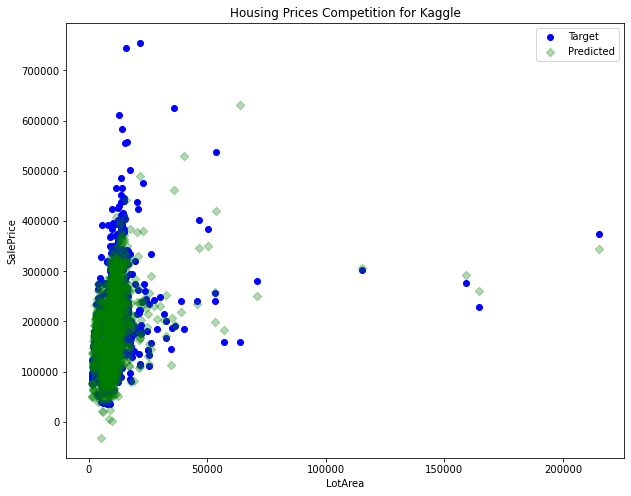

In [29]:
plt.figure(figsize=(10,8))

ax1 = plt.scatter(df_train['LotArea'], y_train[:,], marker='o', c='b')
ax2 = plt.scatter(df_train['LotArea'], predicted[:,], marker='D', c='g', alpha=0.3)


plt.title("Housing Prices Competition for Kaggle")
plt.ylabel('SalePrice')
plt.xlabel('LotArea')
plt.legend([ax1, ax2], ['Target', 'Predicted'], loc='upper right')

plt.show()

### 9. Loading the `test` dataset

In [30]:
df_test = pd.read_csv('test.csv').set_index('Id')
print ('The shape of df_test is: ', df_test.shape)
df_test.head(2)

The shape of df_test is:  (1459, 79)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal


- Choosing numeric features on `test` set

In [31]:
df_TEST_numeric_colmuns = df_test.select_dtypes(include=np.number)
df_TEST_numeric_colmuns.head(2)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,80.0,11622,5,6,1961,1961,0.0,468.0,144.0,...,730.0,140,0,0,0,120,0,0,6,2010
1462,20,81.0,14267,6,6,1958,1958,108.0,923.0,0.0,...,312.0,393,36,0,0,0,0,12500,6,2010


### 10. Fixing Missing features on `test` set

In [32]:
df_TEST_numeric_colmuns.isna().sum().sort_values(ascending=False).head()

LotFrontage     227
GarageYrBlt      78
MasVnrArea       15
BsmtHalfBath      2
BsmtFullBath      2
dtype: int64

`isna()` = `isnull()` There is absolutely no difference

In [33]:
df_TEST_numeric_colmuns.isna().sum().sum()

330

In [34]:
df_TEST_numeric_colmuns.isnull().sum().sum()

330

- Checking Data as `numpy.ndarray`

In [35]:
X_test_raw = np.array(df_TEST_numeric_colmuns)
print(np.sum(np.isnan(X_test_raw)))

330


* Replace missing values using a descriptive statistic `mean`

In [36]:
# imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean') --> Above implemented

X_test_clean = imp_mean.fit_transform(df_TEST_numeric_colmuns)

* Checking Data as `numpy.ndarray` after impute missing features

In [37]:
print(np.sum(np.isnan(X_test_clean)))

0


In [38]:
print(f"X_test_clean Shape: {X_test_clean.shape}")
print(f"X_test_clean Type: {type(X_test_clean)})")
print("Dimension of X_test_clean:", X_test_clean.ndim)

X_test_clean Shape: (1459, 36)
X_test_clean Type: <class 'numpy.ndarray'>)
Dimension of X_test_clean: 2


### 11. z-score normalization on `test` set

**Implementation Note:** When normalizing the features, it is important to store the values used for normalization - the mean value and the standard deviation used for the computations. After learning the parameters from the model, we often want to predict the prices of houses we have not seen before. Given a new `X_test` values, we must first normalize `X_test` using the mean and standard deviation that we had previously computed from the training set.

> This note is borrowed from the lecture notes of the Machine Learning Specialization offered jointly by DeepLearning.AI and Stanford University on Coursera

In [39]:
X_test_norm, X_test_mu, X_test_sigma = zscore_normalize_features(X_test_clean)
print(f"X_test_mu = {X_test_mu}, \n X_test_sigma = {X_test_sigma}")
print('')
print(f"Peak to Peak range by column in Raw        X:{np.ptp(X_test_clean,axis=0)}")   
print(f"Peak to Peak range by column in Normalized X:{np.ptp(X_test_norm,axis=0)}")

X_test_mu = [5.73783413e+01 6.85803571e+01 9.81916107e+03 6.07882111e+00
 5.55380398e+00 1.97135778e+03 1.98366278e+03 1.00709141e+02
 4.39203704e+02 5.26193416e+01 5.54294925e+02 1.04611797e+03
 1.15653461e+03 3.25967786e+02 3.54352296e+00 1.48604592e+03
 4.34454358e-01 6.52024708e-02 1.57093900e+00 3.77655929e-01
 2.85400960e+00 1.04249486e+00 6.38519534e+00 5.81220014e-01
 1.97772122e+03 1.76611797e+00 4.72768861e+02 9.31747772e+01
 4.83139136e+01 2.42433173e+01 1.79437971e+00 1.70644277e+01
 1.74434544e+00 5.81679232e+01 6.10418095e+00 2.00776971e+03], 
 X_test_sigma = [4.27322277e+01 2.05541803e+01 4.95381878e+03 1.43631916e+00
 1.11335786e+00 3.03796544e+01 2.11232242e+01 1.76649255e+02
 4.54955894e+02 1.76632737e+02 4.36960684e+02 4.42594957e+02
 3.98029345e+02 4.20466058e+02 4.40281546e+01 4.85399666e+02
 5.30101695e-01 2.52208566e-01 5.54999592e-01 5.02844263e-01
 8.29503945e-01 2.08400217e-01 1.50837739e+00 6.47198544e-01
 2.57056367e+01 7.75413055e-01 2.16899795e+02 1.277010

In [40]:
np.sum(np.isnan(X_test_norm))

0

In [41]:
print("Type of X_test_norm:",type(X_test_norm))
print ('The shape of X_test_norm is: ', X_test_norm.shape)
print("Dimension of X_test_norm:", X_test_norm.ndim)

Type of X_test_norm: <class 'numpy.ndarray'>
The shape of X_test_norm is:  (1459, 36)
Dimension of X_test_norm: 2


### 12. Predictions on `test` set

In [42]:
print(f"b,w found by gradient descent: {b_final:0.2f},{w_final} ")
m_test,_ = X_test_norm.shape
predicted_Xtest = np.zeros(m_test)

for i in range(m_test):
    predicted_Xtest[i] = np.dot(X_test_norm[i], w_final[i]) + b_final
    #print(f"Prediction: {predicted_Xtest[i]:0.2f}")

b,w found by gradient descent: 180921.20,[[-7678.90001192 -1237.99188431  4290.61110917 ...  -362.14238496
   -135.36885154 -1036.17335459]
 [-7678.90001192 -1237.99188431  4290.61110917 ...  -362.14238496
   -135.36885154 -1036.17335459]
 [-7678.90001192 -1237.99188431  4290.61110917 ...  -362.14238496
   -135.36885154 -1036.17335459]
 ...
 [-7678.90001192 -1237.99188431  4290.61110917 ...  -362.14238496
   -135.36885154 -1036.17335459]
 [-7678.90001192 -1237.99188431  4290.61110917 ...  -362.14238496
   -135.36885154 -1036.17335459]
 [-7678.90001192 -1237.99188431  4290.61110917 ...  -362.14238496
   -135.36885154 -1036.17335459]] 


- Outlier

In [43]:
np.sum(predicted_Xtest < 0)

0

In [44]:
print("Shape of predicted test set:", predicted_Xtest.shape)
print("Dimension of predicted test set:", predicted_Xtest.ndim)

Shape of predicted test set: (1459,)
Dimension of predicted test set: 1


- Metrics

In [45]:
print("R2 Score                           : " + str(r2_score(predicted_Xtest, y_train[:1459,])))
print("Mean Absolute Error                : " + str(mean_absolute_error(predicted_Xtest, y_train[:1459,])))
print("Mean Square Error                  : " + str(mean_squared_error(predicted_Xtest, y_train[:1459,])))
print("Mean Squared Logarithmic Error     : " + str(mean_squared_log_error(predicted_Xtest, y_train[:1459,])))
print("Root Mean Square Error             : " + str(np.sqrt(mean_squared_error(predicted_Xtest, y_train[:1459,]))))
print("Root Mean Squared Logarithmic Error: " + str(np.sqrt(mean_squared_log_error(predicted_Xtest, y_train[:1459,]))))

# ValueError: Mean Squared Logarithmic Error cannot be used when targets contain negative values.

R2 Score                           : -1.1770073703780675
Mean Absolute Error                : 80067.44301213173
Mean Square Error                  : 11356853386.63813
Mean Squared Logarithmic Error     : 0.353955314314531
Root Mean Square Error             : 106568.5384465703
Root Mean Squared Logarithmic Error: 0.5949414377184791


### Back to Pandas for submitting predictions

In [49]:
submission = pd.DataFrame(dict(Id=df_test.index, SalePrice=predicted_Xtest))
submission.head

<bound method NDFrame.head of         Id      SalePrice
0     1461  119523.214715
1     1462  158434.980934
2     1463  178505.619095
3     1464  202938.346682
4     1465  193808.737134
...    ...            ...
1454  2915   59820.075765
1455  2916   67204.410680
1456  2917  178164.346203
1457  2918  104763.287213
1458  2919  257395.006530

[1459 rows x 2 columns]>

In [47]:
submission.describe()

,Id,SalePrice
count,1459.000000,1459.000000
mean,2190.000000,180921.195890
std,421.321334,72251.679017
min,1461.000000,3666.453820
25%,1825.500000,130372.068975
50%,2190.000000,171494.506359
75%,2554.500000,224957.284071
max,2919.000000,658288.419730


In [48]:
submission = submission.astype(int)

In [ ]:
#submission.to_csv('submission.csv', index=False, header=True)

## Acknowledgments

- Machine Learning Specialization offered jointly by DeepLearning.AI and Stanford University on Coursera.
- The housing data was derived from **Kaggle** [House Prices - Advanced Regression Techniques](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview).

>I will be uploading new Notebooks using `SGDRegressor` and `XGBoost` for better predictions.  Let me know if you have any recommendations.  Thanks!